In [2]:
!pip install opencv-python tensorflow

In [3]:

import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


file_path = r'C:\Users\Naman\Desktop\6th sem moocs\dataset\full_df.csv'


df = pd.read_csv(file_path)


print(df.head(3))


   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

        

In [4]:

def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0


In [5]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [6]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [7]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [8]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [9]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [10]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)
print(len(cataract),len(normal))

594 500


In [11]:
import os
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = r'C:\Users\Naman\Desktop\6th sem moocs\dataset\preprocessed_images'
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [12]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [00:03<00:00, 159.64it/s]


In [13]:
len(dataset)

588

In [14]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:04<00:00, 102.50it/s]


In [15]:
len(dataset)

1088

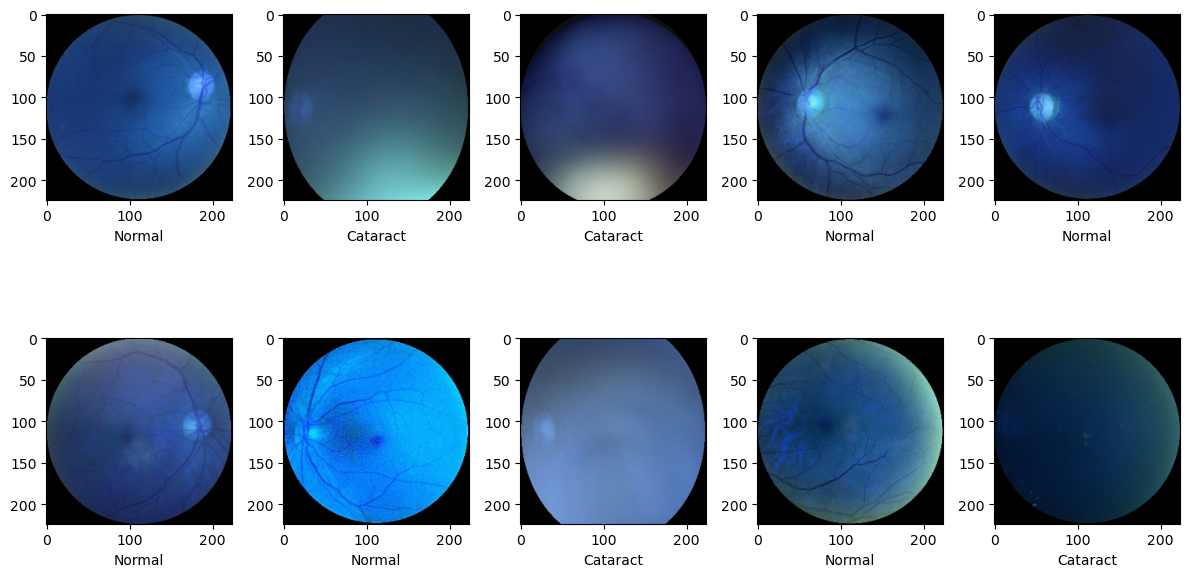

In [16]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()  

In [17]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [19]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [20]:
for layer in vgg.layers:
    layer.trainable = False
    

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [22]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg19.keras", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, save_freq='epoch')
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)


In [24]:
history = model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8112 - loss: 1.5484
Epoch 1: val_accuracy improved from -inf to 0.94037, saving model to vgg19.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 160s 6s/step - accuracy: 0.8140 - loss: 1.5451 - val_accuracy: 0.9404 - val_loss: 1.0616
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9341 - loss: 0.6347
Epoch 2: val_accuracy improved from 0.94037 to 0.95413, saving model to vgg19.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 176s 6s/step - accuracy: 0.9344 - loss: 0.6303 - val_accuracy: 0.9541 - val_loss: 0.9626
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9792 - loss: 0.1435
Epoch 3: val_accuracy did not improve from 0.95413
28/28 ━━━━━━━━━━━━━━━━━━━━ 178s 6s/step - accuracy: 0.9793 - loss: 0.1428 - val_accuracy: 0.9404 - val_loss: 1.0064
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9824 - loss: 0.1429
Epoch 4: val_accuracy improved from 0.95413 to 0.96789, saving model to vgg19.keras
28/28 ━━━━━━━━━━━━━━

In [25]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.9465 - loss: 1.0655
loss: 0.6596355438232422
Accuracy: 0.963302731513977


In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test,y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       105
           1       0.94      0.99      0.97       113

    accuracy                           0.96       218
   macro avg       0.97      0.96      0.96       218
weighted avg       0.96      0.96      0.96       218



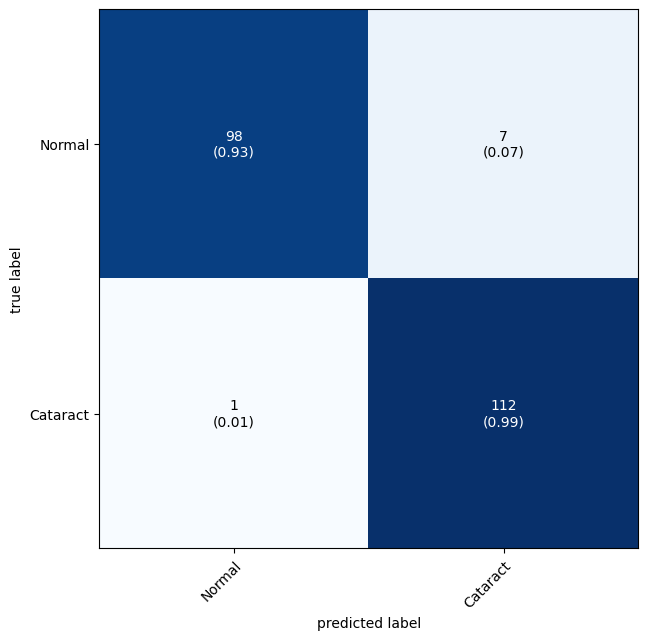

In [27]:
!pip install mlxtend
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

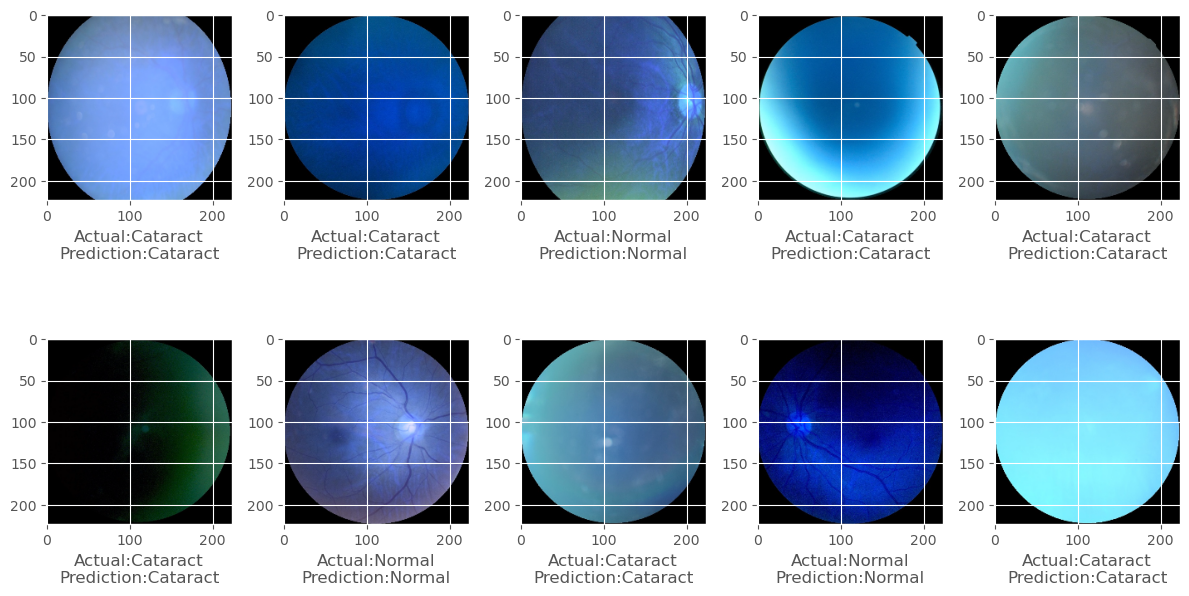

In [40]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 